In [ ]:
import tensorflow as tf
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint
from pathlib import Path
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer

path = 'gdrive/MyDrive/Colab Notebooks/data/SVHN'
checkpoint_path = path + '/checkpoint'
cnn_checkopoint_path = path +'/cnn/checkpoint'

def display_random_images(images, labels):
    idxs = np.random.randint(1,len(images),10)
    fig, ax = plt.subplots(1,10, figsize = (20,2))
    for i, idx in enumerate(idxs): 
        ax[i].set_axis_off()
        if images.shape[3]==3:
            ax[i].imshow(images[idx])
        if images.shape[-1]==1:
            grayImage = images[idx]
            grayImage = grayImage[...,0]
            ax[i].imshow(grayImage, cmap = 'gray')
        ax[i].set_title(f'label: {train_labels[idx][0]}')        

def convert_to_grayscale(image_set):
    return np.mean(image_set, axis = -1, keepdims=1)

def plot_loss_accuracy(history):

  loss = history.history['loss']
  val_loss = history.history['val_loss']
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  fig = plt.figure(figsize=(12, 5))
  fig.add_subplot(121)
  plt.plot(loss)
  plt.plot(val_loss)
  plt.title('Loss vs. Epochs')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Validation'], loc='upper right')

  fig.add_subplot(122)
  plt.plot(accuracy)
  plt.plot(val_accuracy)
  plt.title('Accuracy vs. Epochs')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Validation'], loc='lower right')
  plt.show()


In [ ]:
# Load the dataset from your Drive folder
train = loadmat('gdrive/MyDrive/Colab Notebooks/data/SVHN/train_32x32.mat')
test = loadmat('gdrive/MyDrive/Colab Notebooks/data/SVHN/test_32x32.mat')

In [ ]:
train.keys(), test.keys()

(dict_keys(['__header__', '__version__', '__globals__', 'X', 'y']),
 dict_keys(['__header__', '__version__', '__globals__', 'X', 'y']))

In [ ]:
train_images = train["X"]
train_labels = train['y']
test_images = test["X"]
test_labels = test['y']

print(f'Original shapes: {train_images.shape, train_labels.shape, test_images.shape, test_labels.shape}')

train_images = np.moveaxis(train_images, -1, 0)
test_images = np.moveaxis(test_images, -1, 0)
print(f'Current shapes: {train_images.shape, train_labels.shape, test_images.shape, test_labels.shape}')

Original shapes: ((32, 32, 3, 73257), (73257, 1), (32, 32, 3, 26032), (26032, 1))
Current shapes: ((73257, 32, 32, 3), (73257, 1), (26032, 32, 32, 3), (26032, 1))


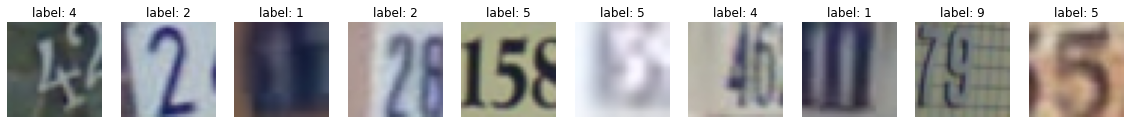

In [ ]:
display_random_images(train_images, train_labels)

In [ ]:
train_images = convert_to_grayscale(train_images)
train_images = train_images / 255.
test_images = convert_to_grayscale(test_images)
test_images = test_images / 255.

print(f'Grayscaled shapes: {train_images.shape, train_labels.shape, test_images.shape, test_labels.shape}')
train_images.dtype

Grayscaled shapes: ((73257, 32, 32, 1), (73257, 1), (26032, 32, 32, 1), (26032, 1))


dtype('float64')

In [ ]:
test_images.shape

(26032, 32, 32, 1)

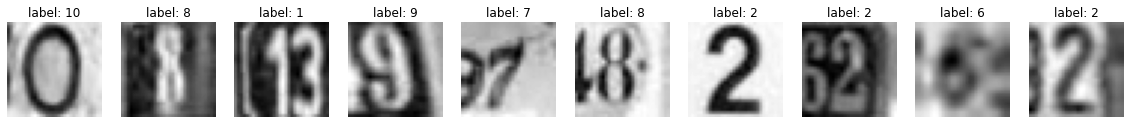

In [ ]:
display_random_images(train_images, train_labels)

## CNN neural network classifier


In [ ]:
def get_CNN_model(wd):
    model = Sequential([
        Conv2D(filters=32, kernel_size=(3, 3), padding = 'SAME', activation='relu', 
        	input_shape=(32, 32, 1), name='conv_1'),
        BatchNormalization(name = 'batchNorm_1'),
        Conv2D(filters=32, kernel_size=(3, 3), padding = 'SAME', activation='relu', name='conv_2'),
        MaxPooling2D(pool_size=(4, 4), name='pool_1'),
        Dropout(.3, name = 'dropout_1'),
        BatchNormalization(name = 'batchNorm_2'),
        Conv2D(filters=32, kernel_size=(3, 3), padding = 'SAME', activation='relu', name='conv_3'),
        MaxPooling2D(pool_size=(4, 4), name='pool_2'),
        Dropout(.3, name = 'dropout_2'),
        Flatten(name='flatten'),
        Dense(units=32, activation='relu', name='dense_1'),
        Dense(units=10, activation='softmax', name='dense_2')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

checkpoint = ModelCheckpoint(filepath=cnn_checkopoint_path,
                             save_freq = 'epoch', 
                             save_best_only=True,
                             monitor = 'val_loss',
                             save_weights_only=True, 
                             verbose = 1)
early_stopping = tf.keras.callbacks.EarlyStopping(
                        monitor="val_loss", mode = 'auto', patience = 4, verbose=1)

cnn_model = get_CNN_model(1e-5)
cnn_model.summary()

cnn_history = cnn_model.fit(train_images, categorized_train_labels, epochs=20, validation_split=.15, batch_size=128, callbacks = [checkpoint, early_stopping],verbose = 1)

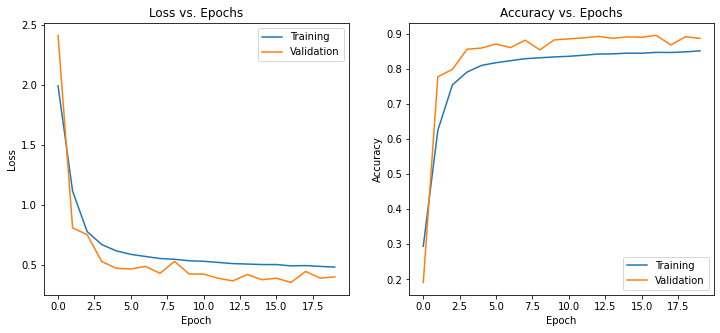

In [ ]:
plot_loss_accuracy(cnn_history)

In [ ]:
loss, accuracy = model.evaluate(test_images, categorized_test_labels, verbose = 0)
print(f'\nLoss on the test set: {loss}\nAccuracy on the test set: {accuracy}')


Loss on the test set: 1.2642732858657837
Accuracy on the test set: 0.6416717767715454


## Model predictions

In [ ]:
mlp_model = get_model(1e-5)
mlp_model.load_weights(checkpoint_path)

cnn_model = get_CNN_model(1e-5)
cnn_model.load_weights(cnn_checkopoint_path)

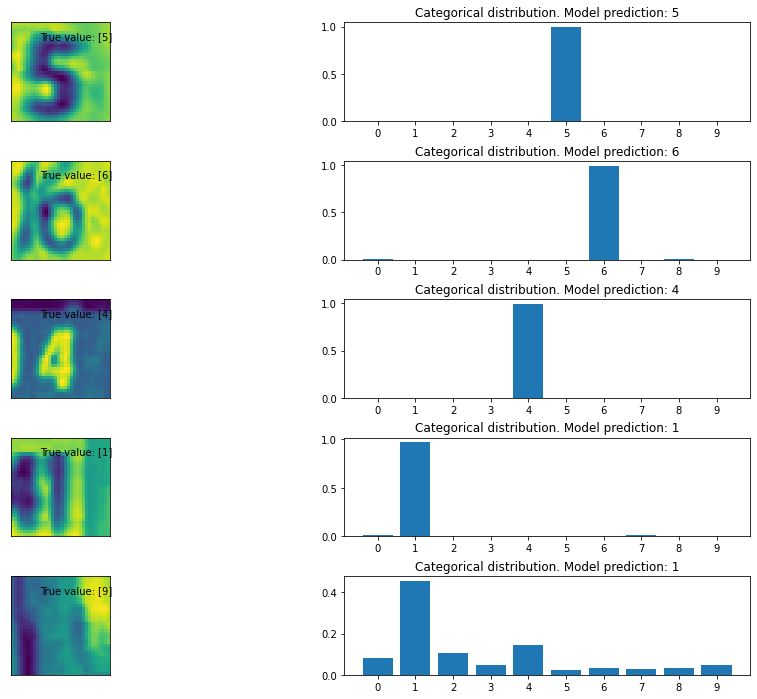

In [ ]:
random_idx = np.random.choice(len(test_images), 5)
randomTestLabels = test_labels[random_idx]
randomTestImages = test_images[random_idx]

cnn_predictions = cnn_model.predict(randomTestImages)

def plot_prediction_probabilities(predictions):
  fig, axes = plt.subplots(5,2, figsize = (16,12))
  fig.subplots_adjust(hspace = .4, wspace = .2)

  for i, (prediction, image, label) in enumerate(zip(predictions, randomTestImages, randomTestLabels)):
    axes[i,0].imshow(np.squeeze(image))
    axes[i,0].get_xaxis().set_visible(False)
    axes[i,0].get_yaxis().set_visible(False)
    axes[i,0].set_title(f"True value: {label[0]}")
    # axes[i,0].text(10. -1, 5, f"True value: {label}")
    axes[i,1].bar(np.arange(len(prediction)), prediction)
    axes[i,1].set_xticks(np.arange(len(prediction)))
    axes[i,1].set_title(f'Categorical distribution. Model prediction: {np.argmax(prediction)}')
  plt.show()

plot_prediction_probabilities(cnn_predictions)